In [0]:
#@title Mount drive /imports. Dynamic fields 

from google.colab import drive
drive.mount('/content/gdrive')

import torch
from torch.autograd import Variable
from torch.autograd import Function
from torchvision import models
from torchvision import utils
import cv2
import sys
import numpy as np
import argparse
import torch.nn as nn 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt


batch_size = 80 #@param {type:"slider", min:1, max:100, step:1}

load_pretrained_model = False #@param {type:"boolean"}

train_on_gpu =True #@param {type:"boolean"}

valid_size =0.2 #@param {type:"slider", min:0.1, max:0.5, step:0.05}


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#@title load saved model

import torch.nn as nn
model = models.alexnet(pretrained=True)

model.classifier[6] = nn.Linear(4096,2)

# model.cuda()


state_dict = torch.load('gdrive/My Drive/last.pt')
model.load_state_dict(state_dict)
# model.cuda()
pre_model = model 
print(model.classifier)



Sequential(
  (0): Dropout(p=0.5)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace)
  (3): Dropout(p=0.5)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace)
  (6): Linear(in_features=4096, out_features=2, bias=True)
)


In [0]:
#@title Transform and Load data 
import torch
import numpy as np
import numpy
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
  
import matplotlib.pyplot as plt
%matplotlib inline

transform =  transforms.Compose([
#     transforms.Grayscale(num_output_channels=1),
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

]
)
dataset =  datasets.ImageFolder("gdrive/My Drive/tb",transform)
dataloader = torch.utils.data.DataLoader(dataset,batch_size = batch_size ,shuffle = True)


num_train = len(dataset) # 800
num_train = 800
num_workers = 0 
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)

classes = ['postive','normal']

print(len(train_loader))
print(len(valid_loader))


data_iter = iter(train_loader)
images, labels = next(data_iter)
print(images.size())


8
2
torch.Size([80, 3, 224, 224])


In [0]:
#@title Load saved model def loss/optimizer

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
state_dict = torch.load('gdrive/My Drive/last.pt')
model.load_state_dict(state_dict)
optimizer = optim.Adam(model.parameters(),lr=0.0001)
import os
model.cuda()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p

In [0]:
#@title Track loss and overall
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

with torch.no_grad():
  for data, target in dataloader:
      if train_on_gpu:
          data, target = data.cuda(), target.cuda()
      output = model(data)
      loss = criterion(output, target)
      test_loss += loss.item()*data.size(0)
      _, pred = torch.max(output, 1)    
      correct_tensor = pred.eq(target.data.view_as(pred))
      correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
      for i in range(data.size(0)):
          label = target.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1

  test_loss = test_loss/len(dataloader.dataset)
  print('Test Loss: {:.6f}\n'.format(test_loss))

  for i in range(2):
      if class_total[i] > 0:
          print('over all  Accuracy of %5s: %2d%% (%2d/%2d)' % (
              classes[i], 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
      else:
          print('over all Accuracy of %5s: N/A (no training examples)' % (classes[i]))

  print('\nOver all Accuracy : %2d%% (%2d/%2d)' % (
      100. * np.sum(class_correct) / np.sum(class_total),
      np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.360761

over all  Accuracy of postive: 88% (358/406)
over all  Accuracy of normal: 96% (380/394)

Over all Accuracy : 92% (738/800)


In [0]:
#@title Track loss and validationValidation loss decreased (0.107660 --> 0.106642).  Saving model ...
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

with torch.no_grad():

  for data, target in valid_loader:
      if train_on_gpu:
          data, target = data.cuda(), target.cuda()
      output = model(data)
      loss = criterion(output, target)
      test_loss += loss.item()*data.size(0)
      _, pred = torch.max(output, 1)    
      correct_tensor = pred.eq(target.data.view_as(pred))
      correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
      for i in range(data.size(0)):
          label = target.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1

  test_loss = test_loss/len(valid_loader.dataset)
  print('Test Loss: {:.6f}\n'.format(test_loss))

  for i in range(2):
      if class_total[i] > 0:
          print('over all  Accuracy of %5s: %2d%% (%2d/%2d)' % (
              classes[i], 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
      else:
          print('over all Accuracy of %5s: N/A (no training examples)' % (classes[i]))

  print('\nOver all Accuracy : %2d%% (%2d/%2d)' % (
      100. * np.sum(class_correct) / np.sum(class_total),
      np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.061374

over all  Accuracy of postive: 93% (75/80)
over all  Accuracy of normal: 93% (75/80)

Over all Accuracy : 93% (150/160)


In [0]:
#@title Track loss and test
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

with torch.no_grad():
  for data, target in train_loader:
      if train_on_gpu:
          data, target = data.cuda(), target.cuda()
      output = model(data)
      loss = criterion(output, target)
      test_loss += loss.item()*data.size(0)
      _, pred = torch.max(output, 1)    
      correct_tensor = pred.eq(target.data.view_as(pred))
      correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
      for i in range(data.size(0)):
          label = target.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1

  test_loss = test_loss/len(train_loader.dataset)
  print('Test Loss: {:.6f}\n'.format(test_loss))

  for i in range(2):
      if class_total[i] > 0:
          print('over all  Accuracy of %5s: %2d%% (%2d/%2d)' % (
              classes[i], 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
      else:
          print('over all Accuracy of %5s: N/A (no training examples)' % (classes[i]))

  print('\nOver all Accuracy : %2d%% (%2d/%2d)' % (
      100. * np.sum(class_correct) / np.sum(class_total),
      np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.314959

over all  Accuracy of postive: 90% (294/326)
over all  Accuracy of normal: 96% (304/314)

Over all Accuracy : 93% (598/640)


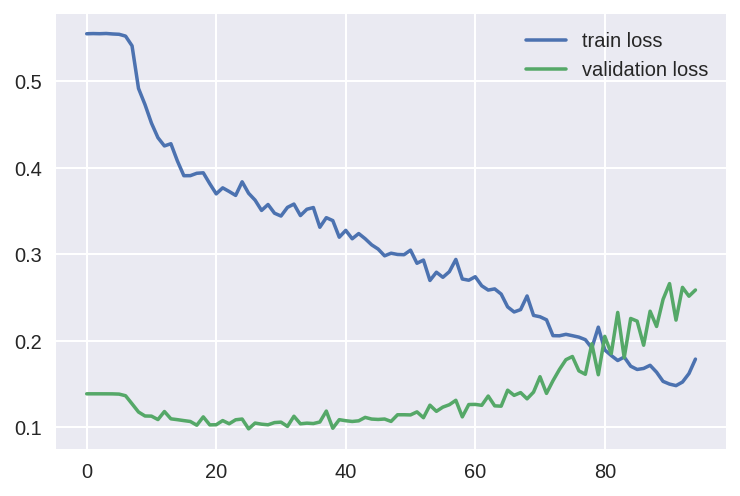

In [0]:
plt.plot(list(train_los),label="train loss")
plt.plot(list(test_los),label='validation loss')
plt.legend()
plt.show()